## 0. Import Libraries

For ease of use and ram, run each indices in different sessions

In [1]:
import numpy as np
import xarray as xr

## 1. Open Data

In [2]:
# change these
season = 'JJA' # DJF, JJA,
time_resample = 6 # options: 1, 3, 6 (resampling)

# bias algorithm
bias_algo = 'QDM'

# path for resampling information
if time_resample != 1:
    path_resample = fr'{time_resample}hrsum'
else:
    path_resample = fr'{time_resample}hr'
    
# general data path
path_general = fr'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data'

# variable name
name_variable_cosmo = 'TOT_PREC'

# saving path (saving with cosmo var name for both era5 and cosmo)
path_save = fr'{path_general}/data/{name_variable_cosmo}/'

# years
years = np.arange(1985, 2006, dtype=int)

In [3]:
# open data
path_dt = fr'{path_general}/cosmo/yearly/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_merged_198501_200512.nc'
    
# chunk recommendation from chatGPT
dt_cosmo = xr.open_dataset(path_dt, 
                     #chunks={'rlat':2,
                     #        'rlon':2
                     #        }
                    )[name_variable_cosmo]

In [4]:
dt_cosmo

<xarray.DataArray 'TOT_PREC' (time: 7748, rlat: 59, rlon: 137)>
[62627084 values with dtype=float64]
Coordinates:
  * rlon     (rlon) float32 -5.55 -5.44 -5.33 -5.22 -5.11 ... 9.08 9.19 9.3 9.41
  * rlat     (rlat) float32 -4.11 -4.0 -3.89 -3.78 -3.67 ... 1.94 2.05 2.16 2.27
  * time     (time) datetime64[ns] 1985-06-01 ... 2005-08-31T18:00:00
    lon      (rlat, rlon) float32 ...
    lat      (rlat, rlon) float32 ...

## 2. Calculate Indices

In [5]:
def find_above(group, q):
    return group.where(group>q)

def count_above(group, q):
    return group.where(group>q).count(dim='time')

def calculate_intensity_index(dt, time_resample):
    
    # groupby and find maximum (rx_xhr)
    rx_xhr = dt.groupby('time.year').reduce(np.max, 
                                            dim='time', 
                                            keep_attrs=True
                                           )

    # Add information about the computation to the dataset's attributes
    rx_xhr.attrs['computation'] = 'grouped by year and took maximum over time dimension'
    rx_xhr.attrs['indice_name'] = fr'rx{time_resample}hr'
    
    return rx_xhr

def n_longest_consecutive(ds, dim):
    ds = ds.cumsum(dim=dim) - ds.cumsum(dim=dim).where(ds == 0).ffill(dim=dim).fillna(0)
    return ds.max(dim='time')

def ge_func(group, dt_q):
    return group > dt_q

def calculate_persistence(group, dt_q, dim='time'):
    dt_ge = ge_func(group, dt_q)
    dt_max_consecutive = n_longest_consecutive(dt_ge, dim=dim)
    
    # no data out of turkey
    return dt_max_consecutive#.where(dt_max_consecutive<360, np.nan)

### 2.1 Intensity Indices

In [6]:
# calculate intensity index
intensity_idx_cosmo = calculate_intensity_index(dt_cosmo, 
                                               time_resample)

In [7]:
intensity_idx_cosmo

<xarray.DataArray 'TOT_PREC' (year: 21, rlat: 59, rlon: 137)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lon      (rlat, rlon) float32 26.18 26.31 26.45 26.58 ... 45.33 45.47 45.62
    lat      (rlat, rlon) float32 35.68 35.69 35.69 35.7 ... 41.63 41.62 41.6
  * rlon     (rlon) float32 -5.55 -5.44 -5.33 -5.22 -5.11 ... 9.08 9.19 9.3 9.41
  * rlat     (rlat) float32 -4.11 -4.0 -3.89 -3.78 -3.67 ... 1.94 2.05 2.16 2.27
  * year     (year) int64 1985 1986 1987 1988 1989 ... 2001 2002 2003 2004 2005
Attributes:
    standard_name:    precipitation_amount
    long_name:        total precipitation amount
    units:            mm
    grid_mapping:     spatial_ref
    cell_methods:     time: sum
    history:          [2023-02-01 16:21:28] : Bias-adjusted with QuantileDelt...
    bias_adjustment:  QuantileDeltaMapping(group=Grouper(name='time'), kind='...
    computation:      grouped by year and took maximum over time dimension
    indice_name:      rx1hr

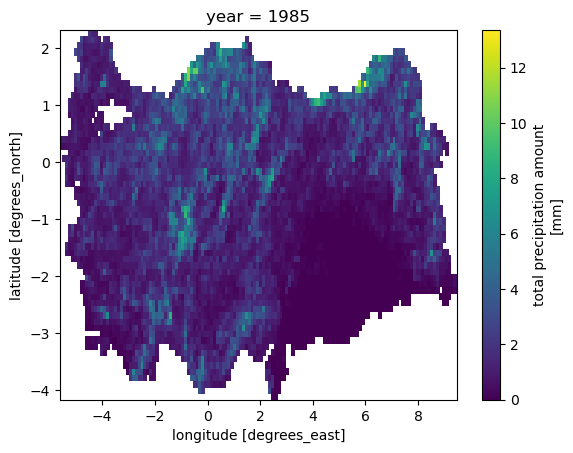

In [8]:
intensity_idx_cosmo[0].plot()

In [9]:
# save index as nc
intensity_indice_name = intensity_idx_cosmo.attrs['indice_name']
intensity_idx_cosmo.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{intensity_indice_name}_198501_200512.nc")

In [26]:
#(xr.open_dataset(r'data/TOT_PREC/era5/era5_JJA_intensity_rx3hr_198501_200512.nc')['tp']*1e3)[0].plot()

In [27]:
#(xr.open_dataset(r'data/TOT_PREC/cosmo/cosmo_JJA_intensity_rx3hr_198501_200512.nc')['TOT_PREC'])[0].plot()

### 2.2. Frequency Indices

Not: Burada projeksiyon verileri için yine referans quantile'ını kullanman gerek, o yüzden kaydetmen gerekecek. Çünkü referans dönem ile karşılaştırabilelim istiyoruz. UNUTMA!

https://community.wmo.int/en/activity-areas/aviation/hazards/precipitation#:~:text=While%20there%20is%20no%20agreed,of%2010%20mm%20per%20hour.

#### 2.2.1 Percentile

In [3]:
# this block is important to calculate percentile of each hour and season
# close this once you are done with calculating percentiles
#q_ask = 0.95

# change this quantile calculation with stable reference quantile while dealing with projection data
#dt_q = dt_cosmo.quantile(q_ask,
#                         dim='time')

# save the quantile data
#dt_q.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_general_percentile{q_ask}_198501_200512.nc")

In [7]:
# use this block instead
q_ask = 0.95
dt_q = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_general_percentile{q_ask}_198501_200512.nc")[name_variable_cosmo]

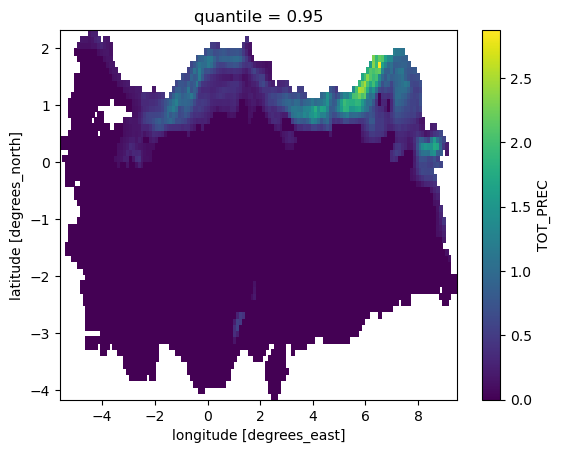

In [8]:
dt_q.plot()

In [9]:
# find x hours above specified quantile threshold
dt_cosmo_above = dt_cosmo.groupby('time.year').apply(lambda group: count_above(group, 
                                                                               dt_q)
                                                    )

dt_cosmo_above.attrs['computation'] = fr'calculated {q_ask} grouped by year and count above {q_ask} over time dimension'
dt_cosmo_above.attrs['indice_name'] = fr'R{time_resample}hr{q_ask}P'

In [10]:
dt_cosmo_above

<xarray.DataArray 'TOT_PREC' (year: 21, rlat: 59, rlon: 137)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
    lon       (rlat, rlon) float32 26.18 26.31 26.45 26.58 ... 45.33 45.47 45.62
    lat       (rlat, rlon) float32 35.68 35.69 35.69 35.7 ... 41.63 41.62 41.6
  * rlon      (rlon) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * rlat      (rlat) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
    quantile  float64 0.95
  * year      (year) int64 1985 1986 1987 1988 1989 ... 2001 2002 2003 2004 2005
Attributes:
    computation:  calculated 0.95 grouped by year and count above 0.95 over t...
    indice_name:  R1hr0.95P

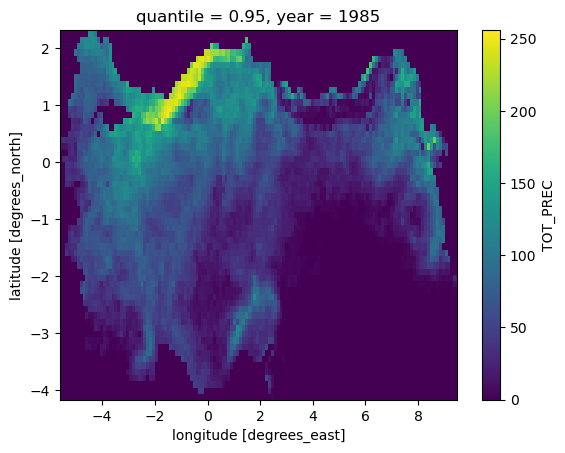

In [11]:
dt_cosmo_above[0].plot()

In [12]:
# cross check
#dt_cosmo.sel(time='2005').where(dt_cosmo.sel(time='2005')>p99_xhr).count(dim='time').plot()

In [12]:
# save index as nc
absolute_indice_name = dt_cosmo_above.attrs['indice_name']
dt_cosmo_above.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{absolute_indice_name}_198501_200512.nc")

#### 2.2.2 Absolute

In [6]:
heavy_rain = 4 * time_resample # 4mm times the resample period

In [7]:
# find x hours above specified quantile threshold
dt_cosmo_above = dt_cosmo.groupby('time.year').apply(lambda group: count_above(group, 
                                                                               heavy_rain)
                                                    )

dt_cosmo_above.attrs['computation'] = fr'grouped by year and count above {heavy_rain}mm over time dimension'
dt_cosmo_above.attrs['indice_name'] = fr'R{time_resample}hr{heavy_rain}mm'

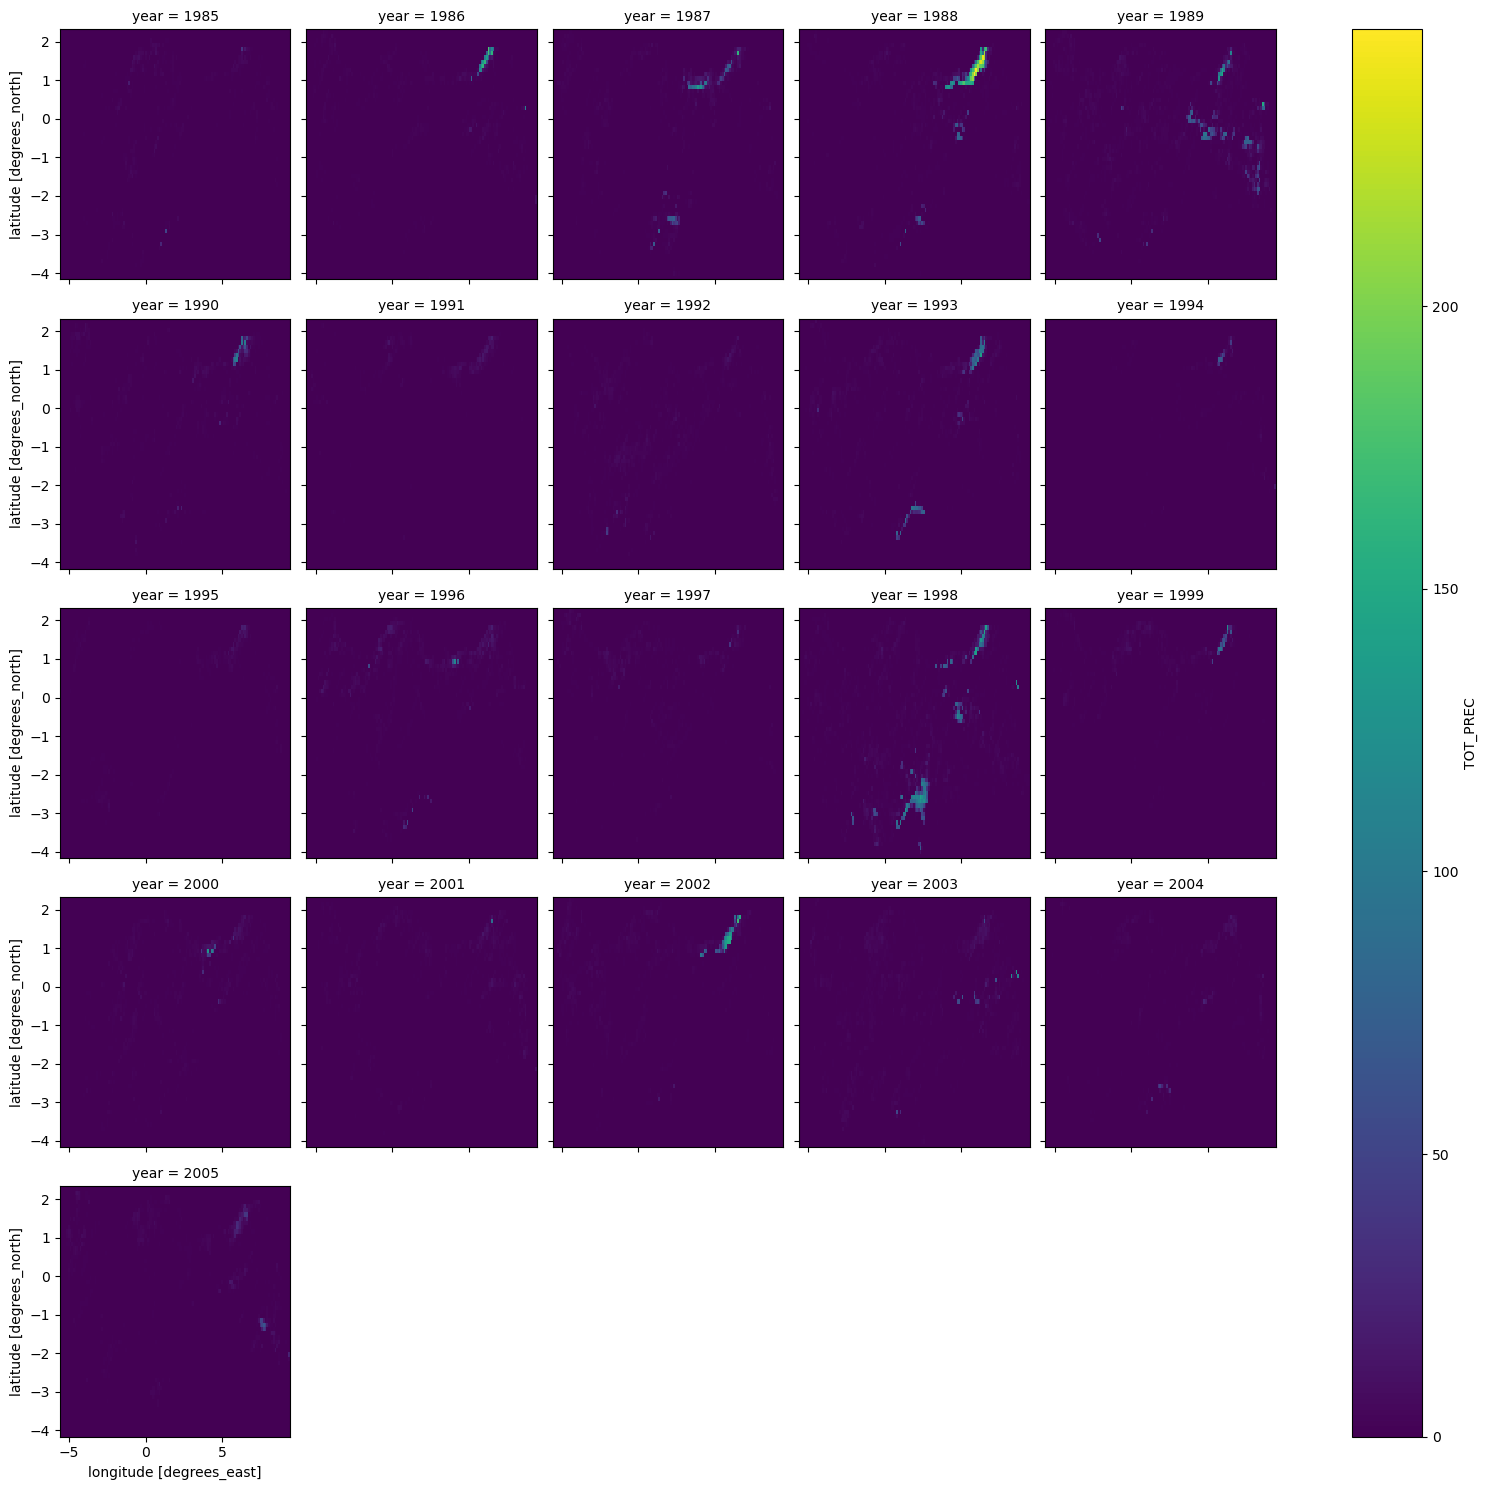

In [8]:
dt_cosmo_above.plot(x='rlon', 
                    y='rlat',
                    col='year',
                    col_wrap=5,)

In [9]:
# save index as nc
absolute_indice_name = dt_cosmo_above.attrs['indice_name']
dt_cosmo_above.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{absolute_indice_name}_198501_200512.nc")

### 2.3 Persistence Indices

Not: Burada projeksiyon verileri için yine referans quantile'ını kullanman gerek, o yüzden kaydetmen gerekecek. Çünkü referans dönem ile karşılaştırabilelim istiyoruz. UNUTMA!

#### 2.3.1 Percentile

In [4]:
#q_ask = 0.95

# change this quantile calculation with stable reference quantile while dealing with projection data
#dt_q = dt_cosmo.quantile(q_ask,
#                         dim='time')

In [ ]:
# use this block instead
q_ask = 0.95
dt_q = xr.open_dataset(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_general_percentile{q_ask}_198501_200512.nc")[name_variable_cosmo]

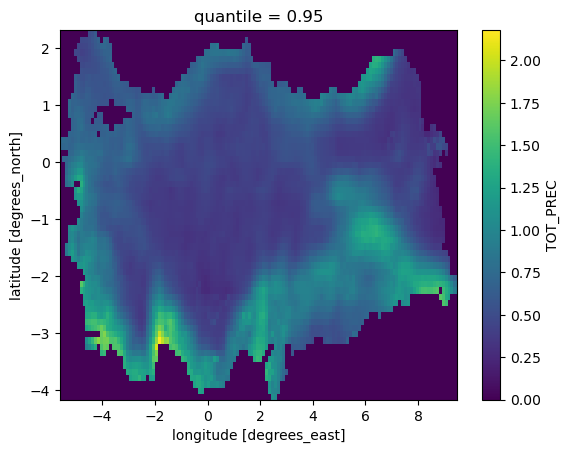

In [7]:
dt_q.plot()

In [8]:
persistence_index = dt_cosmo.groupby('time.year').apply(lambda group: calculate_persistence(group, dt_q))

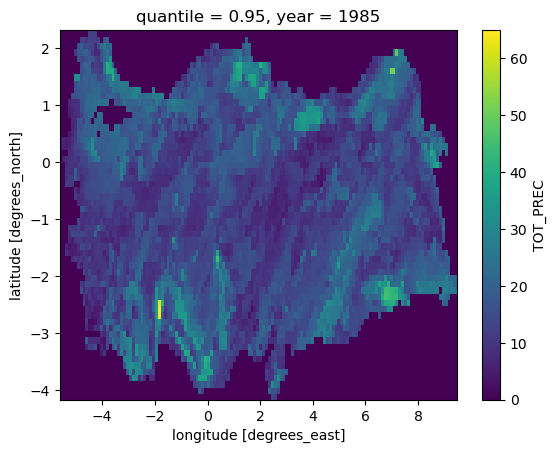

In [9]:
persistence_index[0].plot()

In [10]:
persistence_index.attrs['computation'] = fr'calculated {q_ask} grouped by year and found maximum number of consecutive times that data is above {q_ask} over time dimension'
persistence_index.attrs['indice_name'] = fr'M{time_resample}hrCW{q_ask}P'

In [11]:
# save index as nc
persistence_indice_name = persistence_index.attrs['indice_name']
persistence_index.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{persistence_indice_name}_198501_200512.nc")

#### 2.3.2 Absolute

In [6]:
heavy_rain = 4 * time_resample # 4mm times the resample period

In [7]:
persistence_index = dt_cosmo.groupby('time.year').apply(lambda group: calculate_persistence(group, heavy_rain))

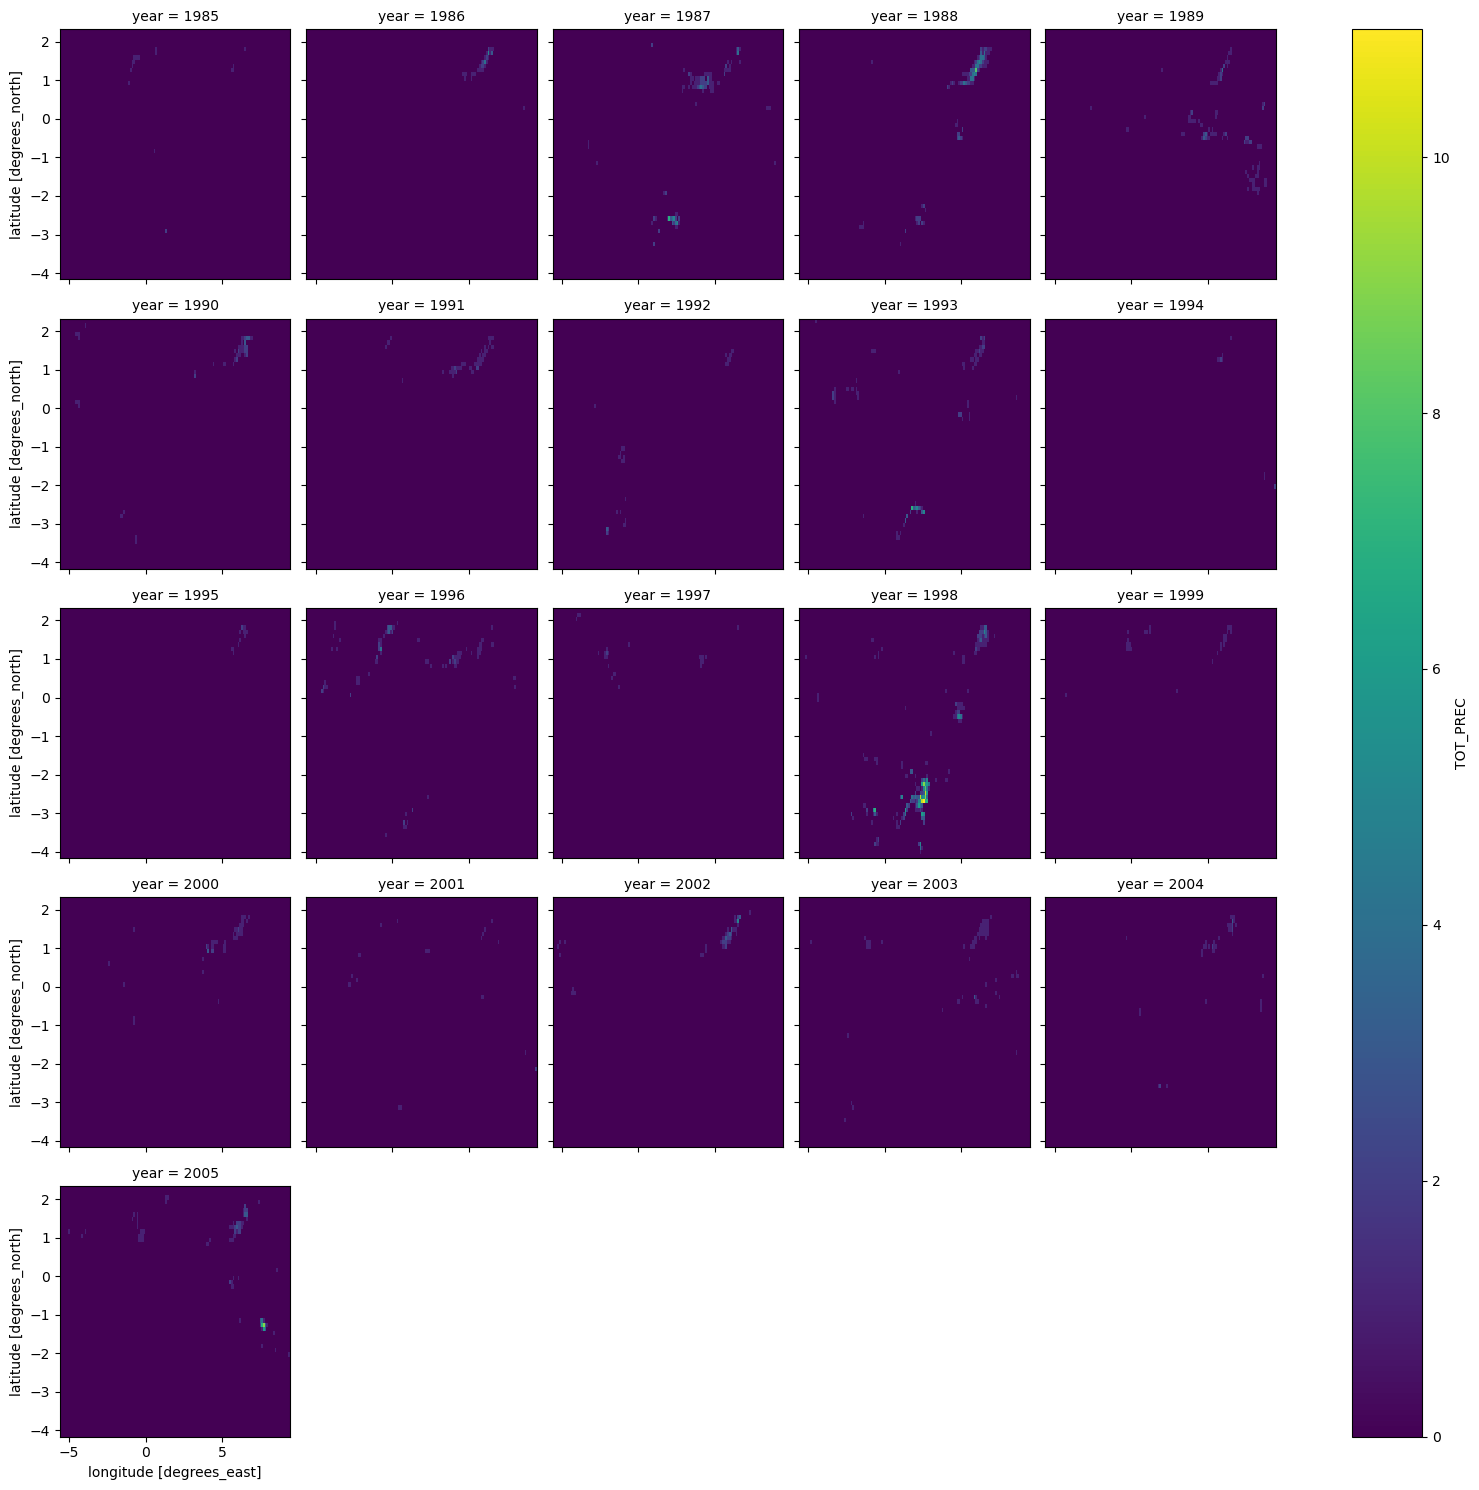

In [8]:
persistence_index.plot(x='rlon', 
                       y='rlat',
                       col='year',
                       col_wrap=5,)

In [9]:
persistence_index.attrs['computation'] = fr'grouped by year and found maximum number of consecutive times that data is above {heavy_rain}mm over time dimension'
persistence_index.attrs['indice_name'] = fr'M{time_resample}hrCW{heavy_rain}mm'

In [10]:
# save index as nc
persistence_indice_name = persistence_index.attrs['indice_name']
persistence_index.to_netcdf(fr"{path_save}/cosmo/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_{persistence_indice_name}_198501_200512.nc")

## 3. Verifying Methodology 

raw persistence calculation below

In [7]:
# find data above q_ask quantile
dt_cosmo_above = (dt_cosmo >= dt_q)

In [8]:
dt_cosmo_above

<xarray.DataArray 'TOT_PREC' (time: 7748, rlat: 59, rlon: 137)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
...
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])
Coordinates:
  * rlon      (rlon) float32 -5.55 -5.44 -5.33 -5.22 ... 9.08 9.19 9.3 9.41
  * rlat      (rlat) float32 -4.11 -4.0 -3.89 -3.78 ... 1.94 2.05 2.16 2.27
  * time      (time) datetime64[ns] 1985-06-01 ... 2005-08-31T18:00:00
    lon       (rlat, rlon) float32 26.18 26.31 26.45 26.58 ... 45.33 45.47 45.62
    lat       (rlat, rlon) float32 35.68 35.69 35.69 35.7 ... 41.63 41.62 41.6
    quantile  float64 0.95

In [9]:
dim = 'time'
#pp = dt_cosmo_above.cumsum(dim=dim) - dt_cosmo_above.cumsum(dim=dim).where(ds == 0)#.ffill(dim=dim).fillna(0)

In [19]:
dt_cosmo.min()

<xarray.DataArray 'TOT_PREC' ()>
array(0.)

In [ ]:
dt_cosmo_above.cumsum(dim=dim).where(dt_cosmo_above==0).ffill(dim=dim)[11].plot()

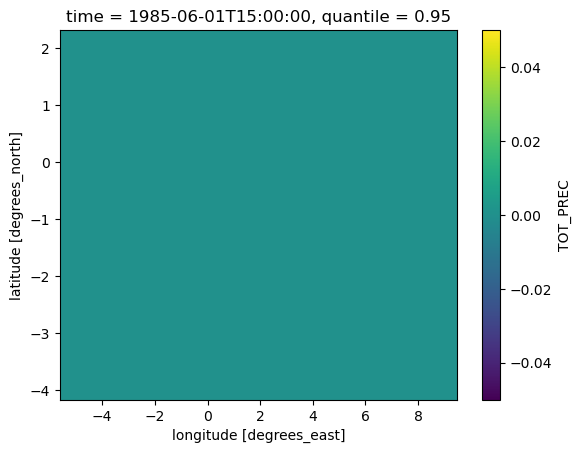

In [43]:
pp[5].plot()

In [35]:
dt_cosmo_above_consecutive = n_longest_consecutive(dt_cosmo_above.sel(time='1985'))

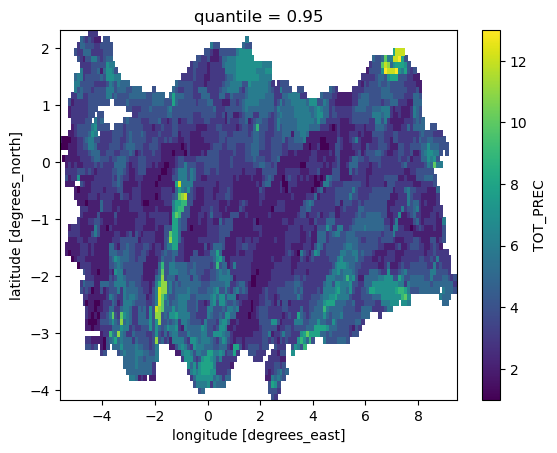

In [37]:
dt_cosmo_above_consecutive.plot()